# [NTDS'19] tutorial 2: build a graph from an edge list
[ntds'19]: https://github.com/mdeff/ntds_2019

[Benjamin Ricaud](https://people.epfl.ch/benjamin.ricaud), [EPFL LTS2](https://lts2.epfl.ch)

* Dataset: [Open Tree of Life](https://tree.opentreeoflife.org)
* Tools: [pandas](https://pandas.pydata.org), [numpy](http://www.numpy.org), [networkx](https://networkx.github.io), [gephi](https://gephi.org/)

## Tools

By convention, the first lines of code are always about importing the packages we'll use.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

Tutorials on pandas can be found at:
* <https://pandas.pydata.org/pandas-docs/stable/10min.html>
* <https://pandas.pydata.org/pandas-docs/stable/tutorials.html>

Tutorials on numpy can be found at:
* <https://docs.scipy.org/doc/numpy/user/quickstart.html>
* <http://www.scipy-lectures.org/intro/numpy/index.html>
* <http://www.scipy-lectures.org/advanced/advanced_numpy/index.html>

A tutorial on networkx can be found at:
* <https://networkx.github.io/documentation/stable/tutorial.html>

## Import the data

We will play with a excerpt of the Tree of Life, that can be found together with this notebook. This dataset is reduced to the first 1000 taxons (starting from the root node). The full version is available here: [Open Tree of Life](https://tree.opentreeoflife.org/about/taxonomy-version/ott3.0).

![Public domain, https://en.wikipedia.org/wiki/File:Phylogenetic_tree.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Phylogenetic_tree.svg/800px-Phylogenetic_tree.svg.png)

In [2]:
tree_of_life = pd.read_csv('data/taxonomy_small.tsv', sep='\t\|\t?', encoding='utf-8', engine='python')

If you do not remember the details of a function:

In [3]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer: Union[str, pathlib.Path, IO[~AnyStr]],
    sep=',',
    delimiter=None,
    header='infer',
    names=None,
    index_col=None,
    usecols=None,
    squeeze=False,
    prefix=None,
    mangle_dupe_cols=True,
    dtype=None,
    engine=None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=False,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression='infer',
    thousands=None,
    decimal=b'.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    escapechar=None,
    comment=None,
    encoding=None,
    dialect=None,
    error_bad_lines=True,
    warn_bad_lines=T

For more info on the separator, see [regex](https://docs.python.org/3.6/library/re.html).

Now, what is the object `tree_of_life`? It is a Pandas DataFrame.

In [4]:
tree_of_life

,uid,parent_uid,name,rank,sourceinfo,uniqname,flags,Unnamed: 7
0,805080,NaN,life,no rank,"silva:0,ncbi:1,worms:1,gbif:0,irmng:0",NaN,NaN,NaN
1,93302,805080.0,cellular organisms,no rank,ncbi:131567,NaN,NaN,NaN
2,996421,93302.0,Archaea,domain,"silva:D37982/#1,ncbi:2157,worms:8,gbif:2,irmng:12",Archaea (domain silva:D37982/#1),NaN,NaN
3,5246114,996421.0,Marine Hydrothermal Vent Group 1(MHVG-1),no rank - terminal,silva:AB302039/#2,NaN,NaN,NaN
4,102415,996421.0,Thaumarchaeota,phylum,"silva:D87348/#2,ncbi:651137,worms:559429,irmng...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
994,5571591,102415.0,uncultured marine thaumarchaeote KM3_175_A05,species,ncbi:1456051,NaN,"environmental,not_otu",NaN
995,5571756,102415.0,uncultured marine thaumarchaeote KM3_46_E07,species,ncbi:1456159,NaN,"environmental,not_otu",NaN
996,5571888,102415.0,uncultured marine thaumarchaeote KM3_02_A10,species,ncbi:1455955,NaN,"environmental,not_otu",NaN
997,5205131,102415.0,thaumarchaeote enrichment culture clone Ec.FBa...,species,ncbi:1238015,NaN,environmental,NaN


The description of the entries is given here:
https://github.com/OpenTreeOfLife/reference-taxonomy/wiki/Interim-taxonomy-file-format

## Explore the table

In [5]:
tree_of_life.columns

Index(['uid', 'parent_uid', 'name', 'rank', 'sourceinfo', 'uniqname', 'flags',
       'Unnamed: 7'],
      dtype='object')

Let us drop some columns.

In [6]:
tree_of_life = tree_of_life.drop(columns=['sourceinfo', 'uniqname', 'flags','Unnamed: 7'])

In [7]:
tree_of_life.head()

,uid,parent_uid,name,rank
0,805080,NaN,life,no rank
1,93302,805080.0,cellular organisms,no rank
2,996421,93302.0,Archaea,domain
3,5246114,996421.0,Marine Hydrothermal Vent Group 1(MHVG-1),no rank - terminal
4,102415,996421.0,Thaumarchaeota,phylum


Pandas infered the type of values inside each column (int, float, string and string). The parent_uid column has float values because there was a missing value, converted to `NaN`

In [8]:
print(tree_of_life['uid'].dtype, tree_of_life.parent_uid.dtype)

int64 float64


How to access individual values.

In [9]:
tree_of_life.iloc[0, 2]

'life'

In [10]:
tree_of_life.loc[0, 'name']

'life'

**Exercise**: Guess the output of the following line:

In [11]:
tree_of_life.uid[0] == tree_of_life.parent_uid[1]

True

Ordering the data.

In [12]:
tree_of_life.sort_values(by='name').head()

,uid,parent_uid,name,rank
297,5246638,102415.0,AB64A-17,no rank - terminal
293,5246632,102415.0,AK31,no rank - terminal
298,5246637,102415.0,AK56,no rank - terminal
202,5246635,102415.0,AK59,no rank - terminal
204,5246636,102415.0,AK8,no rank - terminal


 *Remark:* Some functions do not change the dataframe (option `inline=False` by default).

In [13]:
tree_of_life.head()

,uid,parent_uid,name,rank
0,805080,NaN,life,no rank
1,93302,805080.0,cellular organisms,no rank
2,996421,93302.0,Archaea,domain
3,5246114,996421.0,Marine Hydrothermal Vent Group 1(MHVG-1),no rank - terminal
4,102415,996421.0,Thaumarchaeota,phylum


## Operation on the columns

Unique values, useful for categories:

In [14]:
tree_of_life['rank'].unique()

array(['no rank', 'domain', 'no rank - terminal', 'phylum', 'species',
       'order', 'family', 'genus', 'class'], dtype=object)

Selecting only one category.

In [15]:
tree_of_life[tree_of_life['rank'] == 'species'].head()

,uid,parent_uid,name,rank
7,5205649,4795965.0,uncultured marine crenarchaeote 'Gulf of Maine',species
8,5208050,4795965.0,uncultured marine archaeon DCM858,species
9,5205092,4795965.0,uncultured marine group I thaumarchaeote,species
10,5205072,4795965.0,uncultured Nitrosopumilaceae archaeon,species
11,5208765,4795965.0,uncultured marine archaeon DCM874,species


How many species do we have?

In [16]:
len(tree_of_life[tree_of_life['rank'] == 'species'])

912

In [17]:
tree_of_life['rank'].value_counts()

species               912
no rank - terminal     58
no rank                12
genus                   8
order                   3
family                  3
phylum                  1
class                   1
domain                  1
Name: rank, dtype: int64

**Exercise:** Display the entry with name 'Archaea', then display the entry of its parent.

In [18]:
# Your code here.
print(tree_of_life[tree_of_life.name == 'Archaea'])
print(tree_of_life[tree_of_life.name == 'Archaea'].parent_uid)

      uid  parent_uid     name    rank
2  996421     93302.0  Archaea  domain
2    93302.0
Name: parent_uid, dtype: float64


## Building the graph

Let us build the adjacency matrix of the graph. For that we need to reorganize the data. First we separate the nodes and their properties from the edges.

In [19]:
nodes = tree_of_life[['uid', 'name','rank']]
edges = tree_of_life[['uid', 'parent_uid']]

In [20]:
nodes.head()

,uid,name,rank
0,805080,life,no rank
1,93302,cellular organisms,no rank
2,996421,Archaea,domain
3,5246114,Marine Hydrothermal Vent Group 1(MHVG-1),no rank - terminal
4,102415,Thaumarchaeota,phylum


When using an adjacency matrix, nodes are indexed by their row or column number and not by a `uid`. Let us create a new index for the nodes.

In [21]:
# Create a column for node index.
nodes.reset_index(level=0, inplace=True)
nodes = nodes.rename(columns={'index':'node_idx'})
nodes.head()

,node_idx,uid,name,rank
0,0,805080,life,no rank
1,1,93302,cellular organisms,no rank
2,2,996421,Archaea,domain
3,3,5246114,Marine Hydrothermal Vent Group 1(MHVG-1),no rank - terminal
4,4,102415,Thaumarchaeota,phylum


In [22]:
# Create a conversion table from uid to node index.
uid2idx = nodes[['node_idx', 'uid']]
uid2idx = uid2idx.set_index('uid')
uid2idx.head()

,node_idx
uid,
805080,0
93302,1
996421,2
5246114,3
102415,4


In [23]:
edges.head()

,uid,parent_uid
0,805080,NaN
1,93302,805080.0
2,996421,93302.0
3,5246114,996421.0
4,102415,996421.0


Now we are ready to use yet another powerful function of Pandas. Those familiar with SQL will recognize it: the `join` function.

In [24]:
# Add a new column, matching the uid with the node_idx.
edges = edges.join(uid2idx, on='uid')

In [25]:
# Do the same with the parent_uid.
edges = edges.join(uid2idx, on='parent_uid', rsuffix='_parent')

In [26]:
# Drop the uids.
edges_renumbered = edges.drop(columns=['uid','parent_uid'])

The `edges_renumbered` table is a list of renumbered edges connecting each node to its parent.

In [27]:
edges_renumbered.head()

,node_idx,node_idx_parent
0,0,NaN
1,1,0.0
2,2,1.0
3,3,2.0
4,4,2.0


## Building the (weighted) adjacency matrix

We will use numpy to build this matrix. Note that we don't have edge weights here, so our graph is going to be unweighted.

In [28]:
n_nodes = len(nodes)
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

In [29]:
for idx, row in edges.iterrows():
    if np.isnan(row.node_idx_parent):
        continue
    i, j = int(row.node_idx), int(row.node_idx_parent)
    adjacency[i, j] = 1  # weight
    adjacency[j, i] = 1  # weight to obtain an undirected network

In [30]:
adjacency[:15, :15]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

Congratulations, you have built the adjacency matrix!

## The graph

In [31]:
# A simple command to create the graph from the adjacency matrix.
graph = nx.from_numpy_array(adjacency)

In addition, let us add some attributes to the nodes:

In [32]:
node_props = nodes.to_dict()

In [35]:
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(graph, node_props[key], key)

Let us check if it is correctly recorded:

In [36]:
graph.node[1]

{'node_idx': 1, 'uid': 93302, 'name': 'cellular organisms', 'rank': 'no rank'}

**Exercise 1:**
Build the graph directly from the `edges` table (without using the adjacency matrix).

In [57]:
edges.head()

,uid,parent_uid,node_idx,node_idx_parent
0,805080,NaN,0,NaN
1,93302,805080.0,1,0.0
2,996421,93302.0,2,1.0
3,5246114,996421.0,3,2.0
4,102415,996421.0,4,2.0


In [63]:
edges_renumbered.columns

Index(['source', 'target'], dtype='object')

In [64]:
# Your code here.
edge_graph = nx.from_pandas_edgelist(edges, source= 'node_idx', target= 'node_idx_parent', edge_attr=True)

**Exercise 2:**
Build the graph from the initial `tree_of_life` table by directly iterating over the rows of this table (without building the adjacency matrix).

In [65]:
# Your code here.
g = nx.Graph()

for indx, row in tree_of_life.iterrows():
    if np.isnan(row.parent_uid):
        continue
    g.add_edge(row[0], row[1], attr_dict=row[2:].to_dict())

**Exercise 3:**
Get the adjacency matrix with `nx.adjacency_matrix(graph)` and compare it with what we obtained previously.

In [59]:
# Your code here.
G = nx.adjacency_matrix(graph)
G

<15x15 sparse matrix of type '<class 'numpy.int64'>'
	with 28 stored elements in Compressed Sparse Row format>

## Graph visualization

To conclude, let us visualize the graph. We will use the python module networkx.

The following line is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html). It enables plotting inside the notebook.

In [47]:
%matplotlib inline

You may also try `%matplotlib notebook` for a zoomable version of plots.

Draw the graph with two different [layout algorithms](https://en.wikipedia.org/wiki/Graph_drawing#Layout_methods).

//anaconda3/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


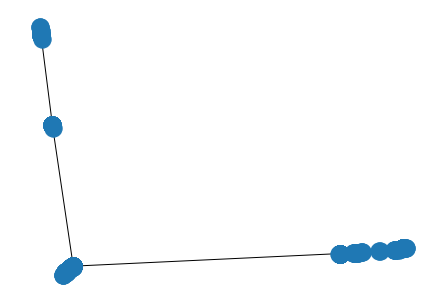

In [48]:
nx.draw_spectral(graph)

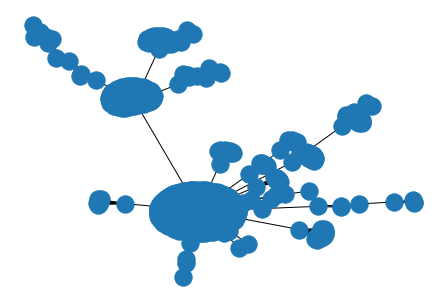

In [49]:
nx.draw_spring(graph)

Save the graph to disk in the `gexf` format, readable by gephi and other tools that manipulate graphs. You may now explore the graph using [gephi](https://gephi.org/) and compare the visualizations.

In [50]:
nx.write_gexf(graph, 'tree_of_life.gexf')